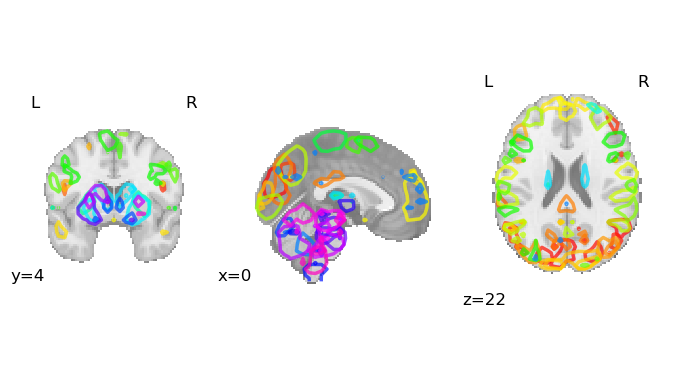

In [1]:
from nilearn import maskers, interfaces, plotting
import matplotlib.pyplot as plt
import numpy as np

n_drop = 10

atlas = "fmriprep/nregions-100_hcp.nii.gz"
preproc = "fmriprep/sub-00_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz"

# plot probabilistic atlas
plotting.plot_prob_atlas(atlas, colorbar=False, draw_cross=False)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

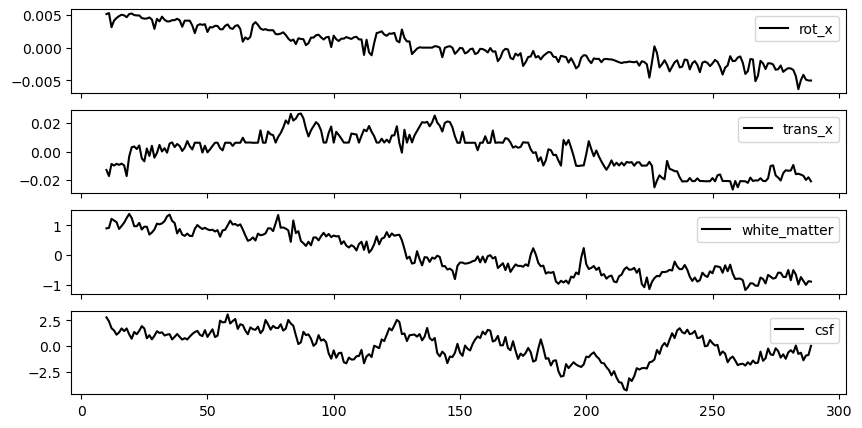

In [2]:
# get fMRIPrep calculated confounds
confounds = interfaces.fmriprep.load_confounds_strategy(preproc, denoise_strategy="simple")[0]

confounds.loc[n_drop:, ["rot_x", "trans_x", "white_matter", "csf"]].plot(
    kind="line", subplots=True, sharex=True, sharey=False, figsize=(10, 5), color="k"
)

In [3]:
masker = maskers.NiftiMapsMasker(
    maps_img=atlas,
    smoothing_fwhm=6,  # gaussian kernel width (in mm)
    standardize="zscore_sample",  # zero mean, unit variance
    standardize_confounds="zscore_sample",
)

# residuals of OLS, drop first `n_drop` timepoints
X = masker.fit_transform(preproc, confounds=confounds)[n_drop:, :]
X.shape

(280, 100)

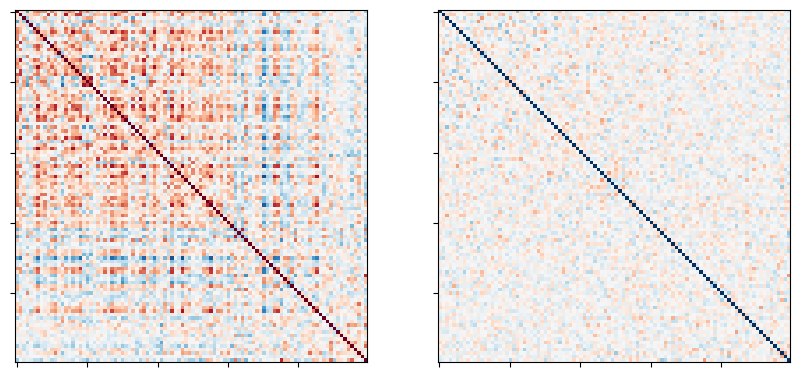

In [4]:
# pairwise correlations
X_corr = X.T @ X / (X.shape[0] - 1)

# partial correlations
# https://en.wikipedia.org/wiki/Partial_correlation#Using_matrix_inversion
X_inv = np.linalg.inv(X_corr)
X_pcorr = -X_inv / np.outer(np.sqrt(np.diag(X_inv)), np.sqrt(np.diag(X_inv)))

# plot matrices
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
kwargs = dict(vmin=-0.8, vmax=0.8, colorbar=False)
plotting.plot_matrix(X_corr, axes=axs[0], **kwargs)
plotting.plot_matrix(X_pcorr, axes=axs[1], **kwargs)